In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import

In [2]:
# ! nvidia-smi
# !pip install tensorflow-gpu
!pip install pyyaml h5py

In [37]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Activation, Dense, Flatten,Bidirectional, Conv1D, MaxPooling1D, LSTM, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.utils import shuffle 
from tensorflow.keras import regularizers
from keras.regularizers import l2,l1
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.metrics import categorical_crossentropy
# from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import itertools
# import re
from  IPython import display
import random
import pathlib
import shutil
import tempfile
from functools import lru_cache
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

##Data

In [4]:
train_path = "/content/drive/MyDrive/Thesis/cmpl_data/train.csv"
test_path = "/content/drive/MyDrive/Thesis/cmpl_data/test.csv"
df = pd.read_csv(train_path)
pf = pd.read_csv(test_path)

In [5]:
# # check the individual character
# def has(matrix):
#     max_value=0
#     for i in range (0,len(matrix)):
#         if (len(matrix[i])>max_value):
#             max_value=len(matrix[i])
#     vectorSize=max_value
#     print('v',vectorSize)
#     count = 0
#     for i in range(len(matrix)):
#         for j in range (0, len(matrix[i])):
#             if (matrix[i][j]=='Z'):
#                 count += 1
#     return count  
# d = df['seq'].values.ravel()
# # p = pf['seq'].values.ravel()
# # v = vf['seq'].values.ravel()
# d = has(d)
# # p = has(p)
# # v = has(v)
# # print('d:',d,'p:',p,'v:',v)
# print('d:',d)

In [6]:
def seq_conversion(matrix):
    # n = [1,2,3,4] #5
    r = [3,4]
    y = [1,2] #5 
    k = [2,3] #5
    m = [1,4]
    s = [1,3]
    w = [2,4] #5
    b = [1,2,3] #5
    h = [1,2,4]
    d = [2,3,4] #5
    v = [1,3,4]
    
    vectorSize= 29922
    # A:4, G:3, C:1, T:2 U:5
    out_data=[]
    for i in range (len(matrix)):
        sample=np.zeros(vectorSize)
        for j in range (0, len(matrix[i])):
            if(matrix[i][j]=='C'):
              sample[j]=1
            elif(matrix[i][j]=='T'):
              sample[j]=2
            elif(matrix[i][j]=='G'):
              sample[j]=3
            elif(matrix[i][j]=='A'):
              sample[j]=4
            # elif(matrix[i][j]=='U'):
            #   sample[j]=5
            # elif(matrix[i][j]=='N'):
            #   sample[j]=0
            elif(matrix[i][j]=='R'):
              sample[j]=random.choice(r)
            elif(matrix[i][j]=='Y'):
              sample[j]=random.choice(y)
            elif(matrix[i][j]=='K'):
              sample[j]=random.choice(k)
            elif(matrix[i][j]=='M'):
              sample[j]=random.choice(m)
            elif(matrix[i][j]=='S'):
              sample[j]=random.choice(s)
            elif(matrix[i][j]=='W'):
              sample[j]=random.choice(w)
            elif(matrix[i][j]=='B'):
              sample[j]=random.choice(b) 
            elif(matrix[i][j]=='H'):
              sample[j]=random.choice(h) 
            elif(matrix[i][j]=='D'):
              sample[j]=random.choice(d) 
            elif(matrix[i][j]=='V'):
              sample[j]=random.choice(v) 
                
            else:
              sample[j] = 0
        out_data.append(sample)
    return out_data

In [7]:
train_data,train_label = df['seq'],df['variant_label']
test_data,test_label = pf['seq'],pf['variant_label']
# train_data,test_data,train_label,test_label = train_test_split(data, label, test_size=0.1, random_state=230)
# Train data conversion
train_data  = train_data.values.ravel()
train_data = np.asarray(seq_conversion(train_data), dtype=np.float32)                      
train_label = train_label.to_numpy().astype('int8')
# Test data conversion
test_data  = test_data.values.ravel()
test_data = np.asarray(seq_conversion(test_data), dtype=np.float32)                      
test_label = test_label.to_numpy().astype('int8')

In [13]:
# Shuffle the train_sample and test_sample
train_data, train_label = shuffle(train_data, train_label)
test_data, test_label = shuffle(test_data, test_label)
# Scaled data
train_data = train_data/4
test_data = test_data/4
# Change the dimension for model purpose
train_data = np.expand_dims(train_data, -1)
test_data = np.expand_dims(test_data, -1)

##Model Code

In [30]:
train_data.shape

(6000, 29922, 1)

In [29]:
# Save model weight's for each epoch and monitor the val_loss
checkpoint_path = '/content/drive/MyDrive/Thesis/code/weight/lstm_weight.ckpt'
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6,restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
  ]

In [45]:
# Build the model

def create_model(): 

    num_classes = 4
    model = Sequential([
    Conv1D(filters=16, kernel_size=6, strides=6,
            input_shape=(train_data.shape[1],train_data.shape[2]),       
    padding="same",activation='relu',kernel_regularizer=regularizers.L2(0.0001)),
    MaxPooling1D(pool_size=6,  strides=6, padding='valid'),
    Conv1D(filters=16, kernel_size=6, strides=6,
            input_shape=(train_data.shape[1],train_data.shape[2]),       
    padding="same",activation='relu',kernel_regularizer=regularizers.L2(0.0001)),
    MaxPooling1D(pool_size=6,  strides=6, padding='valid'),
    Bidirectional(LSTM(units=16,activation='relu',
         kernel_regularizer=regularizers.L2(0.0001),return_sequences=True)),
    # Dropout(rate=0.5),
    Flatten(),
    Dense(num_classes, activation='softmax')
    ])


#   compile the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate= 0.0001),
                metrics=['accuracy'])
  
  
    return model

model = create_model()
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 4987, 16)          112       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 831, 16)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 139, 16)           1552      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 23, 16)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 23, 32)            4224      
_________________________________________________________________
flatten_7 (Flatten)          (None, 736)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)               

In [46]:
# Train the model
batchSize = 6
epoch = 100
history = model.fit(train_data, train_label,
        validation_split=0.2,
        batch_size=batchSize,
        epochs=epoch,  
        shuffle=True,
        verbose=2,
        callbacks=[get_callbacks()])

Epoch 1/100
800/800 - 21s - loss: 1.3906 - accuracy: 0.2567 - val_loss: 1.3878 - val_accuracy: 0.4508

Epoch 00001: saving model to /content/drive/MyDrive/Thesis/code/weight/lstm_weight.ckpt
Epoch 2/100
800/800 - 19s - loss: 1.3846 - accuracy: 0.3338 - val_loss: 1.3781 - val_accuracy: 0.5067

Epoch 00002: saving model to /content/drive/MyDrive/Thesis/code/weight/lstm_weight.ckpt
Epoch 3/100
800/800 - 19s - loss: 1.3589 - accuracy: 0.3871 - val_loss: 1.2983 - val_accuracy: 0.2808

Epoch 00003: saving model to /content/drive/MyDrive/Thesis/code/weight/lstm_weight.ckpt
Epoch 4/100
800/800 - 19s - loss: 1.0811 - accuracy: 0.4958 - val_loss: 1.0028 - val_accuracy: 0.5050

Epoch 00004: saving model to /content/drive/MyDrive/Thesis/code/weight/lstm_weight.ckpt
Epoch 5/100
800/800 - 19s - loss: 1.0154 - accuracy: 0.5325 - val_loss: 0.9821 - val_accuracy: 0.5658

Epoch 00005: saving model to /content/drive/MyDrive/Thesis/code/weight/lstm_weight.ckpt
Epoch 6/100
800/800 - 20s - loss: 0.9938 - ac

##Prediction

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
# test_path =  "/content/drive/MyDrive/Thesis/m_data/joinTest.csv"
# vf = pd.read_csv(test_path)# converting the data as well as store it into a list
# # valid_data = conversion(vf)
# test_data = vf['seq'].values.ravel()
# test_data = np.asarray(seq_conversion(test_data), dtype=np.float32)
# test_label = vf['variant_label'].to_numpy().astype('int8')
# test_data, test_label = shuffle(test_data, test_label)
# test_data = test_data/4
# test_data = np.expand_dims(test_data, -1)

In [ ]:
predictions = model.predict(test_data,batch_size=1,verbose=0)
rounded_predictions = np.argmax(predictions, axis=-1)
cm = confusion_matrix(y_true = test_label, y_pred= rounded_predictions)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       500
           1       0.94      0.96      0.95       500
           2       0.98      0.97      0.98       500
           3       0.97      0.97      0.97       500

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

63/63 - 13s - loss: 0.1418 - accuracy: 0.9690
Restored model, accuracy: 96.90%
Confusion matrix, without normalization
[[487   8   1   4]
 [  8 478   7   7]
 [  4   8 486   2]
 [  0  12   1 487]]


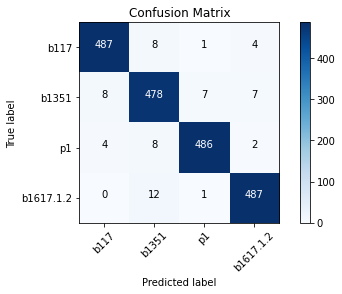

In [ ]:
cm_plot_labels = ['b117','b1351','p1','b1617.1.2']
print(classification_report(test_label,rounded_predictions))
loss, acc = model.evaluate(test_data, test_label, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')